# Capstone 1 - Problem problems

In this capstone exercise, you'll be tasked with constructing a pipeline that drives a visualization, plotting problems in a bar chart.

**We'd like to get the average number of attempts for a problem among all students, then group that by course**. 

Any problems that take an above average number of attempts should jump out at us.

## A few tips

Here are a few tips to help get you started.

- Begin with the **correlated_answers** collection. This collection contains all student submissions in a much more succint format than other collections.

- Remember that each document in **correlated_answers** is one student's performance in an entire course. The problems attempted are accessible at the ``submissions`` key.

- ``submissions`` is an array of the problems. It might be helpful to **$unwind** this array to create a new document for every problem.

- You'll need to **$group** similar problems together! There's other information that you'll need to preserve in the initial grouping phase.

## Required Output

The output you want to reach is

```
[
  {
    "_id": "M036",
    "problems": [
      {
        "problem_id": "5a34333cdac97f48b78748ce",
        "avg_attempts": 1.0626780626780628
      },
      {
        "problem_id": "5a14c3bd7f87b5284fd81e36",
        "avg_attempts": 1.6887608069164266
      },
      ...
    ]
  },
  {
    "_id": "M001",
    "problems": [
      {
        "problem_id": "696106e5cff8ee4269c5eadb"
        "avg_attempts": 0.9933392539964476
      },
      ...
    ]
  },
  ...
    
```

This has been truncated. Your output should include all courses and all problems!

In [8]:
# import our dependencies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pymongo import MongoClient
client = MongoClient()
from utils.workshop import *
sns.set(color_codes=True)
correlated_answers = client.mdbw.correlated_answers

In [13]:
unwind_submissions = {
    "$unwind": "$submissions"
}

"""
Then group by the short offering name (M001, M312, etc...) as well as the
problem_id
calculate the average attempts for this problem
"""
group_by_offering_and_problem = {
    "$group": {
        "_id": {
            "offering": {
                "$substrBytes": ["$_id.offering", 0, 4]
            },
            "problem_id": "$submissions.problem_id"
        },
        "avg_attempts": {
            "$avg": "$submissions.num_attempts"
        }
    }
}

"""
Now that we have problems grouped together, let's regroup them so that
they are all grouped together just by their offering
"""

group_by_offering = {
    "$group": {
        "_id": "$_id.offering",
        "problems": {
            "$push": {
                "problem_id": "$_id.problem_id",
                "avg_attempts": "$avg_attempts"
            }
        }
    }
}

In [14]:
# ensure you supply your aggregation!
courses = list((correlated_answers.aggregate([unwind_submissions, group_by_offering_and_problem, group_by_offering])))
m_print(courses)
# make a copy of our results to use later
results = courses[:]

[
  {
    "_id": "M036",
    "problems": [
      {
        "problem_id": "5a34333cdac97f48b78748ce",
        "avg_attempts": 1.0626780626780628
      },
      {
        "problem_id": "5a14c3bd7f87b5284fd81e36",
        "avg_attempts": 1.6887608069164266
      },
      {
        "problem_id": "5a31a4f90fa481306b858192",
        "avg_attempts": 1.2954545454545454
      },
      {
        "problem_id": "5a4fc55ae433130c6c17ed80",
        "avg_attempts": 1.1127272727272728
      },
      {
        "problem_id": "59ef3c21e43313130dda32a2",
        "avg_attempts": 1.188034188034188
      },
      {
        "problem_id": "5a34333cdac97f48b78748df",
        "avg_attempts": 1.3496932515337423
      },
      {
        "problem_id": "5a34333cdac97f48b78748bd",
        "avg_attempts": 1.2238805970149254
      },
      {
        "problem_id": "5a5289a09237ae699f4f2ecc",
        "avg_attempts": 1.2272727272727273
      },
      {
        "problem_id": "5a4fafabe43313fdf585c2c5",
        "avg_attempt

# Finished?

Run the following cells without modifying anything once you have the proper output. There is no need to change anything. Everything is heavily commented in an attempt to explain what is happening.

# Visualizing

Once you've peformed the necessary transformation, run the following cell to show a nice graph of the "noise" in problem attempts.

While we called these "Problem problems" we should be suspicious. Is the average number of attempts per problem a good indicator?

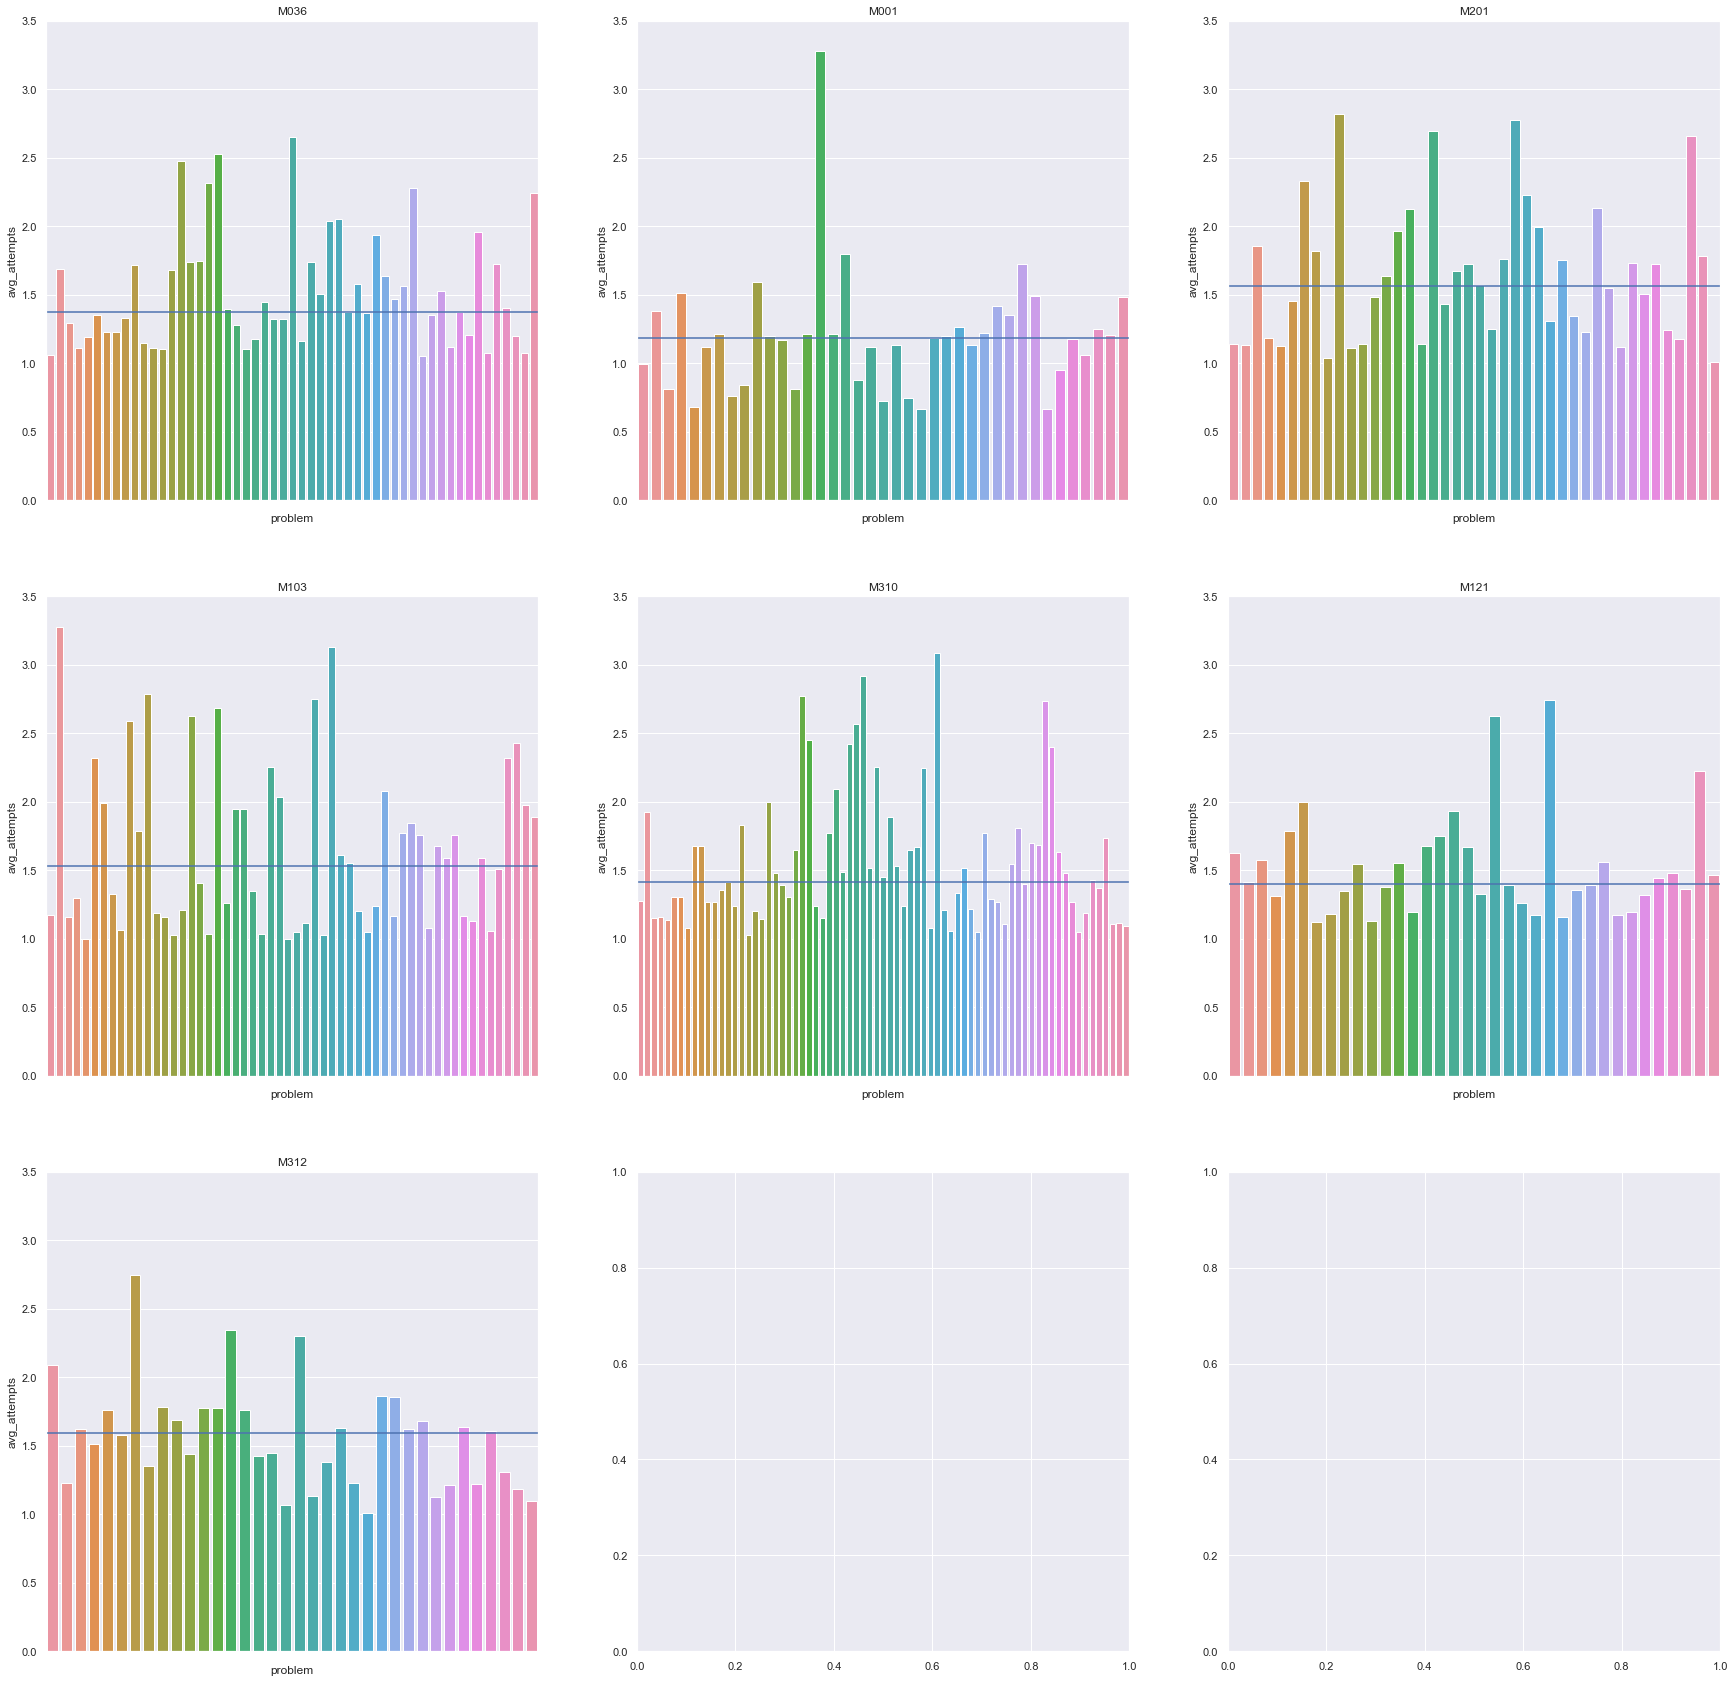

In [15]:
"""
We're constructing a 3d dataframe here
If you aren't familiar with python list comprehensions, this can be read as
for each course in courses:
   create a dictionary: 
       with a key "course" and value of the course name (M001, M121, etc...)
       with a key "problems" that is a dataframe. The dataframe will have the following data":
           for each problem in problems:
               create a dictionary:
                   with a key "problem" and a value of the problem_id
                   with a key "avg_attempts" and a value of the avg_attempts
put all of this into a dataframe
"""
df = pd.DataFrame([{"course": course['_id'], "problems": pd.DataFrame(list(map(lambda x: {"problem": x["problem_id"], "avg_attempts": x["avg_attempts"]}, course['problems'])))} for course in results])

"""
You've seen similar plotting to this. Below every line is commented to describe what it does
"""
# we create a figure(fig) and declare some axes(axs) that the *subplots* will be put into
# we want 3 columns, 3 rows, and a figure size of (30, 30)
fig, axs = plt.subplots(ncols=3, nrows=3,figsize=(30, 30))
# we create a list to lookup into so we can get a numerical index
courses = df['course'].tolist()
# x is necessary to keep track of which subplot we're drawing
x = 0
# we iterate over all of the courses in the main dataframe
for course in df['course']:
    # define a barplot, where the x axis will take the problems, y will be the avg_attempts value
    # data is the sub-dataframe for the particular course
    # ax tells this subplot where to place itself in the axes
    # in python3, // gives us true integer division, so 0//3, 1//3, and 2//3 all return 0
    # 3//3, 4//3, 5//3 all return 1, and so on
    # lastly, set_title to the name of the course that generated this subplot
    bp = sns.barplot(
        x="problem", 
        y="avg_attempts", 
        data=df['problems'][courses.index(course)], 
        ax=axs[x//3, x%3],
    ).set_title(course)
    # get the axes
    axes = bp.axes
    # limit the y axis to 3.5
    axes.set_ylim(0,3.5)
    # figure out what the median value is for all values on the y axis, avg_attempts
    ymed = df['problems'][courses.index(course)]['avg_attempts'].median()
    # draw a median line. Y is how far up we want the line to be. xmin is how far left the line should
    # be drawn, 0 for the the beginning of the plot. xmax, conversely, is how far to the right the line
    # should be drawn. 1 means the end of of the plot (along x axis)
    axes.axhline(y=ymed, xmin=0, xmax=1)
    # remove x labels from the plots
    axes.set_xticklabels([])
    # we're done with this subplot, increment x
    x+=1